In [127]:
# import necessary libraries
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize
from scipy.sparse.linalg import eigsh
from scipy.signal import find_peaks
from scipy.spatial import Delaunay
from scipy.spatial import distance
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import multiprocessing as mp
from sklearn import metrics
import networkx as nx
import numpy as np
import random
import csv

In [128]:
%run ./functions_for_GrapHiC.ipynb

In [152]:
class DataGenerator():
    
    def __init__(self, NumberOfClusters, LocPerCluster, rmin, rmax, IsolatedLoc):
        # frame shape
        self.xmin, self.xmax, self.ymin, self.ymax = -100, 100, -100, 100
        
        # parameters 
        self.NumberOfClusters   = NumberOfClusters
        self.numbers = LocPerCluster
        self.rmin = rmin
        self.rmax = rmax
        self.IsolatedLoc = IsolatedLoc
        
        # data generation steps
        self.PlaceCenters()
        self.FillClusters()
        self.AddIsolatedLoc()
        self.scrumble()
        
    def PlaceCenters(self):
        print('in PlaceCenters')
        #self.centers = [(-60, 42), (65, -40), (-35, -60), (60, 60)]
        #generate random centers of clusters, avoiding the borders
        # version with no condition: 
        #self.centers      = np.random.uniform(low=[self.xmin + self.rmax, self.ymin + self.rmax],
        #                                      high=[self.xmax-self.rmax, self.ymax-self.rmax],
        #                                      size=(self.NumberOfClusters,2))
        
        # Version with |ci - cj| < 2*rmax:
        self.centers      = np.random.uniform(low=[self.xmin + self.rmax, self.ymin + self.rmax],
                                              high=[self.xmax-self.rmax, self.ymax-self.rmax],
                                              size=(1,2))
        n = 1
        count = 0
        while (n < self.NumberOfClusters) and (count < (self.NumberOfClusters * 10)):
            count += 1
            if (count  == ((self.NumberOfClusters * 10) -2) ): print('cannot place any more clusters')
            new_center = np.random.uniform(low=[self.xmin + self.rmax, self.ymin + self.rmax],
                                              high=[self.xmax-self.rmax, self.ymax-self.rmax],
                                              size=(1,2))
            is_accepted = True
            for i, c in enumerate(self.centers):
                if np.linalg.norm(c - new_center) < (2 * self.rmax): is_accepted = False
            
            if is_accepted: 
                n += 1
                self.centers = np.vstack([self.centers, new_center])
                
            # faire qqch pour éviter une boucle infinie! 
            
                 

    def FillClusters(self):
        print('in Fill Clusters')
        np.random.seed(20)

        self.truelabels = []
        self.k          = 0

        points  = np.array([[0, 0]])  

        for i, center in enumerate(self.centers):
            temp = give_circle_points(self.rmin, self.rmax, self.numbers[i], center)
            self.truelabels = self.truelabels + [self.k for t in list(range(self.numbers[i]))]
            self.k          = self.k + 1
            for t in temp:
                points = np.append(points, [t], axis=0)

        points = points[1:]
        self.points = points
        
        
    def AddIsolatedLoc(self):
        print('in Add Isolated loc')
        noise      = np.random.uniform(low=[-100, -100], high=[100, 100], size=(100,2))
        self.truelabels = self.truelabels + [self.k for t in  list(range(100))]
        self.k          = self.k + 1
        for t in noise:
            self.points = np.append(self.points, [t], axis=0)
        
        
    def scrumble(self):
        print('in scrumble')
        
    def plot(self):
        P1              = self.points 
        Sigma1          = np.ones((P1.shape[0], 2, 2)) * 0.5
        Sigma1[:, 0, 1] = 0
        Sigma1[:, 1, 0] = 0
        n1              = np.ones((P1.shape[0], 1)).ravel()
        self.truelabels      = np.array(self.truelabels)


        plot_points(P1, self.truelabels, 'Input Data: GT', 4)
        plot_points(P1, self.truelabels * 0, 'Input Data', 4)
        

In [153]:
NumberOfClusters = 200
LocPerCluster = [40] * NumberOfClusters 
rmin = 6
rmax = 7


datagen = DataGenerator(NumberOfClusters = NumberOfClusters,
                        LocPerCluster = LocPerCluster,
                        rmin = rmin,
                        rmax = rmax, IsolatedLoc = 0)

in PlaceCenters
cannot place any more clusters
in Fill Clusters
in Add Isolated loc
in scrumble


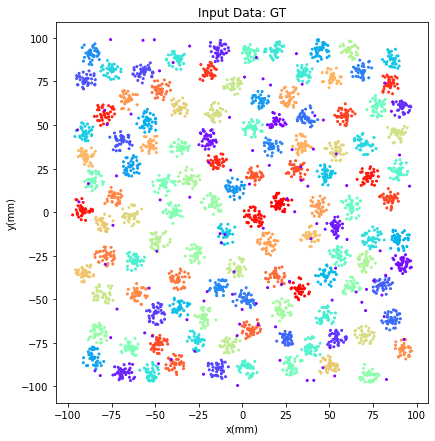

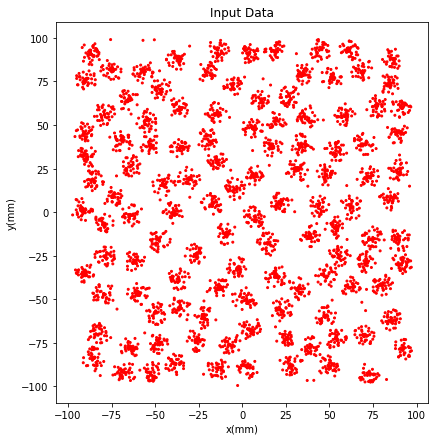

In [154]:
datagen.plot()

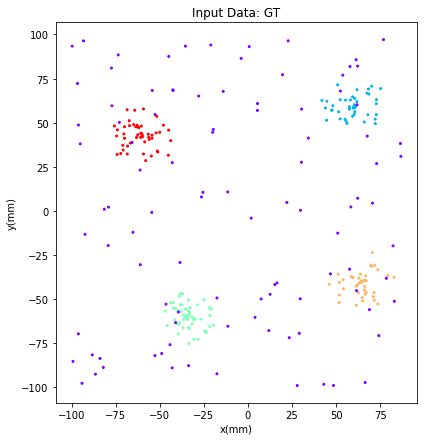

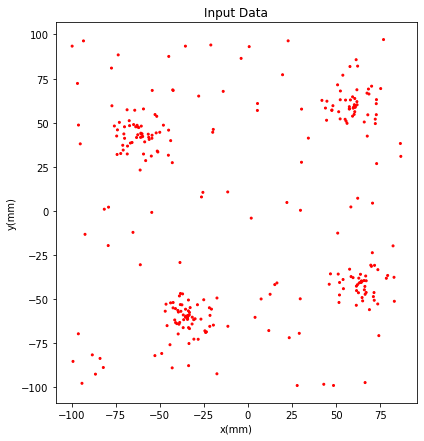

In [12]:
def give_circle_points(rmin, rmax, n_points, center):
    # This function generates "n_points" uniform points inside a circle with center of "center", 
    # and a random radius between "r_min" and "rmax"
    r         = np.random.uniform(rmin, rmax, 1)
    r_s       = np.random.uniform(0, r, n_points)
    theta_s   = np.random.uniform(0, np.pi*2, n_points)
    sin_theta = np.sin(theta_s)
    cos_theta = np.cos(theta_s)
    points    = [[center[0] + r_s[i] * cos_theta[i], center[1] + r_s[i] * sin_theta[i]] for i in range(n_points)]  
    return points


np.random.seed(10)


truelabels = []
k          = 0

centers = [(-60, 42), (65, -40), (-35, -60), (60, 60)]
points  = np.array([[0, 0]])
numbers = [50, 40, 55, 45]  

for i, center in enumerate(centers):
    temp = give_circle_points(16, 20, numbers[i], center)
    truelabels = truelabels + [k for t in list(range(numbers[i]))]
    k          = k + 1
    for t in temp:
        points = np.append(points, [t], axis=0)

points = points[1:]  


noise      = np.random.uniform(low=[-100, -100], high=[100, 100], size=(100,2))
truelabels = truelabels + [k for t in  list(range(100))]
k          = k + 1
for t in noise:
    points = np.append(points, [t], axis=0)

P1              = points 
Sigma1          = np.ones((P1.shape[0], 2, 2)) * 0.5
Sigma1[:, 0, 1] = 0
Sigma1[:, 1, 0] = 0
n1              = np.ones((P1.shape[0], 1)).ravel()
truelabels      = np.array(truelabels)




plot_points(P1, truelabels, 'Input Data: GT', 4)
plot_points(P1, truelabels * 0, 'Input Data', 4)

In [90]:
NbOfCenters       = 10
centres_test      = np.random.uniform(low=[-100, -100], high=[100, 100], size=(10,2))

In [91]:
centres_test

array([[ 51.84778798, -35.52984434],
       [  0.40442902,  16.76621306],
       [-46.67982349,  42.76932891],
       [ -8.54577859,  30.04627448],
       [  0.5337677 , -13.72128692],
       [ 43.55329222, -97.52783149],
       [-83.94112499,  15.27458907],
       [ 62.72434329,  12.30724673],
       [ 20.71833923, -55.88383496],
       [ 83.90820852, -58.89985992]])

In [92]:
type(centres_test)

numpy.ndarray

In [88]:
centres_test.shape

(10, 2)

In [89]:
centres_test = np.append(centres_test, np.array([[1,1]]))

TypeError: 'list' object cannot be interpreted as an integer

In [79]:
centres_test

array([ 83.65925948,  96.92436924,  99.409429  ,   3.18479213,
        40.01686172, -84.68824496,  80.22829935,  62.71652942,
       -28.18765735,  95.14074742, -22.8027806 , -96.7581216 ,
       -96.26510893,   8.82790867, -11.37073655, -94.85997051,
       -26.33909709, -15.93589842, -18.91920775,  99.61553293,
         1.        ,   1.        ])

In [80]:
centres_test.shape

(22,)

In [82]:
type(centres_test)

numpy.ndarray

In [74]:
np.array([[1,1]]).shape

(1, 2)

In [93]:
newrow = [1,1]

In [97]:
centres_test = np.vstack([centres_test, newrow])

In [98]:
centres_test

array([[ 51.84778798, -35.52984434],
       [  0.40442902,  16.76621306],
       [-46.67982349,  42.76932891],
       [ -8.54577859,  30.04627448],
       [  0.5337677 , -13.72128692],
       [ 43.55329222, -97.52783149],
       [-83.94112499,  15.27458907],
       [ 62.72434329,  12.30724673],
       [ 20.71833923, -55.88383496],
       [ 83.90820852, -58.89985992],
       [  1.        ,   1.        ]])

In [118]:
N = [40] * 5 + [50] * 10

In [119]:
N

[40, 40, 40, 40, 40, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]